# Singapore - Neighbourhoods Clustering

In this project, we are going to be clustering the Neighbourhoods of Singapore based on the venues available for the Neighoburhoods and also on the number of aribnb listings for those neighbourhoods.

* The neighbourhood information of Singapore is downloaded as a geojason file
* The number of airbnb listings in each of those neighbourhoods is downloaded as a file.
* The venues for the neighbourhoods are retrieved using Foursquare API calls.
* A single Dataframe which has the neighbourhood, neighbourhood_group, venues, venue category and the no of listings near those venues categorised beased on the closeness to the venue is created.
* K-Means clustering algorithm is run on this dataframe and the clusters are obtained.
* The clusters are visually represented in a map.

## Importing Libraries

In [1]:
# Before we get the data and start exploring it, let's download all the dependencies that we will need.

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Get Singapore Neighbourhood Information

In [2]:
# The neighbourhood data along with the coordinates is present as a geojason file.
# "features" key has all the relevant data and this is extracted from which the required information can be parsed
!wget -q -O 'neighbourhoods.geojson' http://data.insideairbnb.com/singapore/sg/singapore/2019-11-26/visualisations/neighbourhoods.geojson
print('Data downloaded!')

with open('neighbourhoods.geojson') as json_data:
    singapore_data = json.load(json_data)
neighborhoods_data = singapore_data['features']

Data downloaded!


### Loading the data into a pandas Dataframe

In [3]:
# define the dataframe columns
column_names = ['neighbourhood', 'neighbourhood_group', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighbourhoods = pd.DataFrame(columns=column_names)

All the data from neighborhoods_data is sent through a For loop and the required information about the neighbourhood, its group and coordinates are extracted and appended to the "neighbourhoods" dataframe

In [4]:
for data in neighborhoods_data:
    #borough = neighborhood_name = data['properties']['borough'] 
    neighbourhood = data['properties']['neighbourhood'] 
    neighbourhood_group = data['properties']['neighbourhood_group']
    
    neighbourhood_latlon = data['geometry']['coordinates'][0]

    array = np.asarray(neighbourhood_latlon)
    for val in array:
        neighbourhood_lat = array[0][0][1]
        neighbourhood_lon = array[0][0][0]
        neighbourhoods = neighbourhoods.append({'neighbourhood': neighbourhood,
                                          'neighborhood_group': neighbourhood_group,
                                          'Latitude': neighbourhood_lat,
                                          'Longitude': neighbourhood_lon}, ignore_index=True)


### Data manipulation - Part 1

Duplicates in the Dataframe are dropped and it is sorted per the "neighbourhood_group" and "neighbourhood" columns. Also, the index of the dataframe is reset as the duplicates have been dropped already necessitating the recreating of the index.

In [5]:
neighbourhoods.drop_duplicates(subset ="neighbourhood", inplace = True) 
neighbourhoods.reset_index(drop=True, inplace = True)
neighbourhoods.sort_values(['neighborhood_group', 'neighbourhood'], inplace = True)
neighbourhoods.reset_index(drop = True, inplace = True)
neighbourhoods.drop(columns = "neighbourhood_group", inplace = True)
neighbourhoods

,neighbourhood,Latitude,Longitude,neighborhood_group
0,Bishan,1.355512,103.856863,Central Region
1,Bukit Merah,1.292155,103.831806,Central Region
2,Bukit Timah,1.335491,103.818446,Central Region
3,Downtown Core,1.299782,103.859423,Central Region
4,Geylang,1.313323,103.906706,Central Region
5,Kallang,1.327819,103.868743,Central Region
6,Marina East,1.284839,103.881079,Central Region
7,Marina South,1.281284,103.872517,Central Region
8,Marine Parade,1.301993,103.919509,Central Region
9,Museum,1.301364,103.845425,Central Region


Here is a quick look at the number of neighborhoods and neighborhood groups

In [6]:
print('The dataframe has {} neighbourhood groups and {} neighborhoods.'.format(
        len(neighbourhoods['neighborhood_group'].unique()),
        neighbourhoods.shape[0]
    )
)

The dataframe has 5 neighbourhood groups and 55 neighborhoods.


## Use geopy library to get the latitude and longitude values of a sample neighbourhood in Singapore.

Use geopy library to get the latitude and longitude values of Woodlands, Singapore

In [7]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
address = 'Woodlands, Singapore'

geolocator = Nominatim(user_agent="Singapore_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Central Region of Singapore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Central Region of Singapore are 1.436897, 103.786216.


### Create a map of Singapore with neighborhoods superimposed on top.

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


In [8]:
# create map of Singapore using latitude and longitude values
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  
    
map_singapore

## Venues in Singapore neighbourhoods

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

### Define Foursquare Credentials and Version

In [9]:
CLIENT_ID = 'B3XCMZ514I3YPECZI5YOH1AXMP10G1WR4F2HKL3WSKDS22OA' # your Foursquare ID
CLIENT_SECRET = 'HQTFN0GZ40HNL3BGJA3APCS0W0AB0SB1IXKBZ25BHPLHGTMR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: B3XCMZ514I3YPECZI5YOH1AXMP10G1WR4F2HKL3WSKDS22OA
CLIENT_SECRET:HQTFN0GZ40HNL3BGJA3APCS0W0AB0SB1IXKBZ25BHPLHGTMR


### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's latitude and longitude values.

In [10]:
neighborhood_latitude = neighbourhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude =neighbourhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighbourhoods.loc[0, 'neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bishan are 1.355512, 103.856863.


Now, let's get the top 100 venues that are in Bishan within a radius of 500 meters.

In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius


 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=B3XCMZ514I3YPECZI5YOH1AXMP10G1WR4F2HKL3WSKDS22OA&client_secret=HQTFN0GZ40HNL3BGJA3APCS0W0AB0SB1IXKBZ25BHPLHGTMR&v=20180605&ll=1.355512,103.856863&radius=500&limit=100'

Send the GET request and examine the resutls

In [12]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e2b09f0963d29001bbdf05c'},
 'response': {'headerLocation': 'Serangoon',
  'headerFullLocation': 'Serangoon, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 1.3600120045000046,
    'lng': 103.86135585976268},
   'sw': {'lat': 1.3510119954999955, 'lng': 103.85237014023733}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c8a1afd1797236a255e5e88',
       'name': 'Kian Seng Seafood Restaurant 建成海鲜馆',
       'location': {'address': '4013 Ang Mo Kio Industrial Park 1',
        'crossStreet': 'Ang Mo Kio Ave 10',
        'lat': 1.358801969042067,
        'lng': 103.85469570147679,
        'labeledLatLngs': [{'label': 'display',
          'lat': 1.358801969042067,
        

### Let's create a function to repeat the same process to all the neighborhoods of Singapore

In [13]:
def getNearbyVenues(names, group, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, grp, lat, lng in zip(names, group, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            grp,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Neighborhood Group',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

calling the above function to get the details for all neighborhoods in singapore

In [14]:
all_venues = getNearbyVenues(names=neighbourhoods['neighbourhood'],
                                   group =  neighbourhoods['neighborhood_group'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )

Bishan
Bukit Merah
Bukit Timah
Downtown Core
Geylang
Kallang
Marina East
Marina South
Marine Parade
Museum
Newton
Novena
Orchard
Outram
Queenstown
River Valley
Rochor
Singapore River
Southern Islands
Straits View
Tanglin
Toa Payoh
Bedok
Changi
Changi Bay
Pasir Ris
Paya Lebar
Tampines
Central Water Catchment
Lim Chu Kang
Mandai
Sembawang
Simpang
Sungei Kadut
Woodlands
Yishun
Ang Mo Kio
Hougang
North-Eastern Islands
Punggol
Seletar
Sengkang
Serangoon
Boon Lay
Bukit Batok
Bukit Panjang
Choa Chu Kang
Clementi
Jurong East
Jurong West
Pioneer
Tengah
Tuas
Western Islands
Western Water Catchment


Lets check the size of the resulting dataframe.

In [15]:
print(all_venues.shape)


(1025, 8)


Let's find out how many unique categories can be curated from all the returned venues

In [16]:
print('There are {} uniques categories.'.format(len(all_venues['Venue Category'].unique())))

There are 199 uniques categories.


a quick look at the dataframe

In [17]:
all_venues.head(5)

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bishan,Central Region,1.355512,103.856863,Kian Seng Seafood Restaurant 建成海鲜馆,1.358802,103.854696,Chinese Restaurant
1,Bishan,Central Region,1.355512,103.856863,SBS Transit: Bus 22,1.355269,103.857354,Bus Line
2,Bishan,Central Region,1.355512,103.856863,Bread Store,1.355643,103.857164,Bakery
3,Bishan,Central Region,1.355512,103.856863,300 Bishan Road,1.354266,103.855159,Train Station
4,Bishan,Central Region,1.355512,103.856863,Tai Hwan Park,1.355454,103.859718,Park


Let's check how many venues were returned for each neighborhood

In [18]:
all_venues.groupby('Neighborhood').count()

,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Ang Mo Kio,6,6,6,6,6,6,6
Bedok,9,9,9,9,9,9,9
Bishan,7,7,7,7,7,7,7
Boon Lay,2,2,2,2,2,2,2
Bukit Batok,10,10,10,10,10,10,10
Bukit Merah,65,65,65,65,65,65,65
Bukit Panjang,6,6,6,6,6,6,6
Bukit Timah,4,4,4,4,4,4,4
Central Water Catchment,4,4,4,4,4,4,4


### Data manipulation - Part 2

Lets see all the unique categories of all the venues returned.

In [19]:
all_venues['Venue Category'].unique()

array(['Chinese Restaurant', 'Bus Line', 'Bakery', 'Train Station',
       'Park', 'Playground', 'Coffee Shop', 'Pizza Place',
       'Electronics Store', 'Salad Place', 'Food Court',
       'Japanese Restaurant', 'Indonesian Restaurant', 'Noodle House',
       'Shopping Mall', 'Café', 'Hotel', 'Nightclub', 'Indian Restaurant',
       'Soup Place', 'Frozen Yogurt Shop', 'Cosmetics Shop',
       'Ramen Restaurant', 'Thai Restaurant', 'Supermarket', 'Bar',
       'Asian Restaurant', 'Gourmet Shop', 'Gas Station', 'Movie Theater',
       'Multiplex', 'Fast Food Restaurant', 'Department Store',
       'Deli / Bodega', 'Sandwich Place', 'Clothing Store', 'Steakhouse',
       'Gym', 'Market', 'Snack Place', 'Italian Restaurant',
       'Gym / Fitness Center', 'Furniture / Home Store', 'Tunnel',
       'Trail', 'Cocktail Bar', 'Art Gallery', 'Restaurant', 'Hookah Bar',
       'Peruvian Restaurant', 'Beer Bar', 'Tea Room', 'Jazz Club',
       'Neighborhood', 'Seafood Restaurant', 'Yoga Studio'

As the project involves clustering neighborhoods based on the venue categories which are considered to be Tourist attractions, lets create a new dataframe with only the required neighbourhoods and their venues.

In [20]:
# creating a list of the required venues.
venues_list = ['Tunnel','Trail','Scenic Lookout','Water Park','Beach','River','History Museum','Theme Park','Theme Park Ride / Attraction','Art Museum','Aquarium','Pier', 'Boat or Ferry','Cruise','Art Gallery','Monument / Landmark','Waterfront','Harbor / Marina','Hot Spring','Historic Site']
# creating a dataframe from the list of required venues.
req_venues = all_venues[all_venues['Venue Category'].isin(venues_list)]
# sorting the dataframe based on neighbourhoods and resetting the index of the dataframe
req_venues.sort_values('Neighborhood', inplace = True)
req_venues.reset_index(drop = True, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Taking a quick look at the resulting dataframe. It can be seen below that the dataframe now has information about the Neighbourhoods, neighbourhood groups, the coordinates of the neighbourhoods, the venues and their coordinates and the venue category.

In [21]:

req_venues

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bedok,East Region,1.314518,103.963586,National Sailing Centre,1.315256,103.962025,Harbor / Marina
1,Bedok,East Region,1.314518,103.963586,East Coast Park Area G,1.314402,103.959101,Beach
2,Bedok,East Region,1.314518,103.963586,Six Pipes Jetty,1.314745,103.963305,Beach
3,Bedok,East Region,1.314518,103.963586,East Coast Double Jetty,1.313993,103.963529,Pier
4,Bedok,East Region,1.314518,103.963586,East Coast Park Area H,1.315794,103.964489,Beach
5,Bedok,East Region,1.314518,103.963586,NSC Jetty,1.315332,103.961775,Pier
6,Boon Lay,West Region,1.299885,103.687743,Mobil Terminal 4,1.298241,103.690407,Harbor / Marina
7,Boon Lay,West Region,1.299885,103.687743,Nautical Yard,1.302786,103.684593,Harbor / Marina
8,Bukit Batok,West Region,1.348935,103.770283,Surviving the Japanese Occupation: War and its...,1.352615,103.768982,History Museum
9,Bukit Batok,West Region,1.348935,103.770283,The Fire Station,1.348819,103.770621,Historic Site


## Download the Airbnb listings for Singapore Neighbourhoods

The airbnb listings for all the neighbourhoods of Singapore are available as a CSV file. The file is read and the information is downloaded into a pandas Dataframe.

It can be seen from the results that the data has information about the coordinates of the properties listed in airbnb for those neighbourhoods as well.

In [22]:
!wget -q -O 'listings.csv' http://data.insideairbnb.com/singapore/sg/singapore/2019-11-26/visualisations/listings.csv
print('Data downloaded!')
#Read csv
filename = 'listings.csv'
# CSV file loaded into a dataframe.
listings = pd.read_csv(filename)
listings.head(5)

Data downloaded!


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,49091,COZICOMFORT LONG TERM STAY ROOM 2,266763,Francesca,North Region,Woodlands,1.44255,103.79580,Private room,82,180,1,2013-10-21,0.01,2,365
1,50646,Pleasant Room along Bukit Timah,227796,Sujatha,Central Region,Bukit Timah,1.33235,103.78521,Private room,81,90,18,2014-12-26,0.26,1,365
2,56334,COZICOMFORT,266763,Francesca,North Region,Woodlands,1.44246,103.79667,Private room,68,6,20,2015-10-01,0.19,2,365
3,71609,Ensuite Room (Room 1 & 2) near EXPO,367042,Belinda,East Region,Tampines,1.34541,103.95712,Private room,202,1,15,2019-09-07,0.16,8,352
4,71896,B&B Room 1 near Airport & EXPO,367042,Belinda,East Region,Tampines,1.34567,103.95963,Private room,93,1,24,2019-10-13,0.24,8,349


## Data Manipulation - 3

Below code is to have only the airbnb listings of the neighbourhoods in the data frame req_venues. This ensures that the analysis is only for the required neighborhoods.

In [23]:
# Downsizing the airbnb listings dataframe to include information about only the neighbourhoods that are available in the Venues dataframe that was created earlier.
listings = listings[listings['neighbourhood'].isin(req_venues['Neighborhood'].unique())]
# sorting the dataframe and resetting the index
listings.sort_values('neighbourhood', inplace = True)
listings.reset_index(drop = True, inplace = True)
# Not all the neighbourhoods in the req_venues dataframe has properties listed in the airbnb dataset. Hence removing the neighbourhoods that dont have a rental listing from the dataframe.
req_venues = req_venues[req_venues['Neighborhood'].isin(listings['neighbourhood'].unique())]
# sorting and resetting the index of the dataframe.
req_venues.sort_values('Neighborhood', inplace = True)
req_venues.reset_index(drop = True, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ensuring equal no of neighbourhoods in both dataframes

In [24]:
print(len(listings['neighbourhood'].unique()))
print(len(req_venues['Neighborhood'].unique()))

20
20


Also verify that its the same neighbourhoods.

In [25]:
listings['neighbourhood'].unique()

array(['Bedok', 'Bukit Batok', 'Bukit Panjang', 'Bukit Timah', 'Clementi',
       'Downtown Core', 'Geylang', 'Jurong East', 'Mandai',
       'Marina South', 'Marine Parade', 'Outram', 'Pasir Ris', 'Punggol',
       'Rochor', 'Sengkang', 'Singapore River', 'Southern Islands',
       'Toa Payoh', 'Woodlands'], dtype=object)

In [26]:
req_venues['Neighborhood'].unique()

array(['Bedok', 'Bukit Batok', 'Bukit Panjang', 'Bukit Timah', 'Clementi',
       'Downtown Core', 'Geylang', 'Jurong East', 'Mandai',
       'Marina South', 'Marine Parade', 'Outram', 'Pasir Ris', 'Punggol',
       'Rochor', 'Sengkang', 'Singapore River', 'Southern Islands',
       'Toa Payoh', 'Woodlands'], dtype=object)

### Distance between Venues and airbnb listings

Now, lets create a new Data frame which has information about the distance between the venues in each neighbourhood and each of the airbnb listings in the neighbourhoods in which the venue is located.

Below is the function that will be used to calculate the distance two locations identified by their coordinates using the haversine formula.

In [27]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r



As described, the code below will cycle through all the items in req_venues and for each of those venues, compare it with the airbnb listings and get the distance between the venue and the listsings using the haversine formula function.

In [28]:
# Separate lists for the Venue category, neighbourhoods, Venue and the distance are created as we loop through the entries.

distance = []
neighbourhoods = []
venues = []
category = []

old_venue = ''
for i in range(len(req_venues)):
    
    
    cur_venue = req_venues.iloc[i,4]
    
    if (old_venue != cur_venue):
        old_venue = cur_venue
        for j in range(len(listings)):
            if( req_venues.iloc[i,0] == listings.iloc[j,5]):
                # latitude and longitude of the venue
                cen_lat = req_venues.iloc[i,5]
                cen_lon = req_venues.iloc[i,6]
                # latitude and longitude of the airbnb listing
                t_lat = listings.iloc[j,6]
                t_lon = listings.iloc[j,7]
                # calling the function
                a = haversine(cen_lat, cen_lon, t_lat, t_lon)
                # appending the values to the separate lists of category, neighbourhoods, venues and distance.
                category.append(req_venues.iloc[i,7])
                neighbourhoods.append(req_venues.iloc[i,0])
                venues.append(cur_venue)
                distance.append(a)
                

creating a dictionary using the lists generated from above and converting it to a dataframe

In [29]:
# A dictionary is created with the keys as Neighbourhoods, Venues, Category, Distance and the values as the lists created above
new_dict = {'Neighbourhoods':neighbourhoods ,'Venues':venues,'Category':category, 'Distance': distance }
# converting the dictionary to a pandas Dataframe
new_df = pd.DataFrame(new_dict)


lets quickly check the resulting Dataframe and its size.

In [30]:
new_df.head()

,Neighbourhoods,Venues,Category,Distance
0,Bedok,National Sailing Centre,Harbor / Marina,2.124623
1,Bedok,National Sailing Centre,Harbor / Marina,5.360416
2,Bedok,National Sailing Centre,Harbor / Marina,5.500462
3,Bedok,National Sailing Centre,Harbor / Marina,5.345480
4,Bedok,National Sailing Centre,Harbor / Marina,5.256135


In [31]:
new_df.shape

(8102, 4)

### Data manipulation - 4

### Categorising Distance into bins

Next we are going to categorise the distance calculated from the previous step based on the proximity to the venue as "close", "moderately close" or "far".

Before that, lets see statistical information about distance column in the dataframe.

In [32]:
new_df['Distance'].describe()

count    8102.000000
mean        2.243489
std         1.862642
min         0.004952
25%         0.586457
50%         1.819851
75%         3.345302
max         6.918065
Name: Distance, dtype: float64

In [33]:
pd.cut(new_df['Distance'], bins=3).value_counts()

(-0.00196, 2.309]    4821
(2.309, 4.614]       1898
(4.614, 6.918]       1383
Name: Distance, dtype: int64

In [ ]:
#new_df.groupby(['Neighbourhoods','closeness']).count()

using binning techniques, lets categorise the distance information from a continuous variable into different predefined discreet bins. The method used is the cut method which does not assure the equal distribution in all bins

In [34]:
#defining the no of bins as 3
pd.cut(new_df['Distance'], bins=3).value_counts()
# defining the bins
closeness = ['close', 'moderately close', 'far']
# defini the bins edges 0-2, 2-4, 4-7
cut_bins = [0, 2, 4, 7]
# creating a new column and assigning the value from binning the distance into it.
new_df['closeness'] = pd.cut(new_df['Distance'], bins=cut_bins, labels=closeness)
new_df.head(5)

,Neighbourhoods,Venues,Category,Distance,closeness
0,Bedok,National Sailing Centre,Harbor / Marina,2.124623,moderately close
1,Bedok,National Sailing Centre,Harbor / Marina,5.360416,far
2,Bedok,National Sailing Centre,Harbor / Marina,5.500462,far
3,Bedok,National Sailing Centre,Harbor / Marina,5.345480,far
4,Bedok,National Sailing Centre,Harbor / Marina,5.256135,far


taking a look at the dimension of the dataframe.

In [35]:

new_df.shape

(8102, 5)

removing duplicate venues from the dataframe

In [36]:
#sorting the dataset
req_venues.sort_values('Venue', inplace = True)
#req_venues.reset_index(drop = True, inplace = True)
# dropping duplicate venues which has the same name and coordinates from the dataset and resetting the index information
req_venues.drop_duplicates(subset = 'Venue',keep='last',inplace = True)
req_venues.reset_index(drop = True, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Counts of airbnb listings in each bins

creating columns to indicate counts of airbnb listings in each bins for every venue present in all Neighbourhoods.

In [37]:
#Initially the counts are assigned a value of 0.
req_venues['close stay'] = 0
req_venues['moderately close stay'] = 0
req_venues['far away stay'] = 0

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

creating a separate list to get the counts of airbnb listings available for each venue based on the closeness

In [38]:
#new_df.groupby(['Neighbourhoods', 'Category','Venues', 'closeness']).count()
stay_counts = new_df.groupby(['Venues', 'closeness']).count()
stay_counts_list = []
stay_counts_list = stay_counts['Category']
len(stay_counts_list)
stay_counts_list[0]

17.0

In [39]:
stay_counts.tail(30)

Neighbourhoods  \
Venues                                             closeness                          
Trick Eye Museum                                   close                       18.0   
                                                   moderately close             NaN   
                                                   far                          NaN   
Universal Studios Singapore                        close                       18.0   
                                                   moderately close             NaN   
                                                   far                          NaN   
Universal Studios Singapore - Guest Services Lobby close                       17.0   
                                                   moderately close             1.0   
                                                   far                          NaN   
Universal Studios Singapore's Ticket Booth         close                       16.0   
                                                   moderately close             2.0   
                                                   far                          NaN   
Water Playground                                   close                        1.0   
                                                   moderately close             NaN   
                                                   far                          NaN   
WaterWorld                                         close                       18.0   
                                                   moderately close             NaN   
                                                   far                          NaN   
West Coast Beach                                   close                      116.0   
                                                   moderately close             NaN   
                                                   far                          NaN   
West Coast Breakwater                              close                      116.0   
                                                   moderately close             NaN   
                                                   far                          NaN   
Woodlands North Jetty                              close                       46.0   
                                                   moderately close            32.0   
                                                   far                          NaN   
Woodlands Waterfront Jetty                         close                       51.0   
                                                   moderately close            27.0   
                                                   far                          NaN   

                                                                     Category  \
Venues                                             closeness                    
Trick Eye Museum                                   close                 18.0   
                                                   moderately close       NaN   
                                                   far                    NaN   
Universal Studios Singapore                        close                 18.0   
                                                   moderately close       NaN   
                                                   far                    NaN   
Universal Studios Singapore - Guest Services Lobby close                 17.0   
                                                   moderately close       1.0   
                                                   far                    NaN   
Universal Studios Singapore's Ticket Booth         close                 16.0   
                                                   moderately close       2.0   
                                                   far                    NaN   
Water Playground                                   close                  1.0   
                                                   moderately close  

Below code will retrieve the counts of listings from the above created list and populate it in the respective columns in the dataframe.

In [40]:
# Logic to populate the counts from the list into the columns of the dataframe
old_venue = ''
i = 0
j = 0
# outer fol loop to loop through the list that has the counts of airbnb listings of all venues based on the distance bins.
for i in range(i,len(stay_counts_list)):
# inner for loop to loop through the dataframe for which the counts are to be populated.
    for j in range(j,len(req_venues)):
        #cur_venue = req_venues.iloc[j,4]
            # populate the close stay column of the dataframe
            req_venues.iloc[j,8] = stay_counts_list[i]
            #print(i,j, stay_counts_list[i])
            i = i + 1
            # populate the moderately close stay of the dataframe
            req_venues.iloc[j,9] = stay_counts_list[i]
            #print(i,j, stay_counts_list[i])
            i = i + 1
            # populate the far away stay of the dataframe
            req_venues.iloc[j,10] = stay_counts_list[i]
            #print(i,j, stay_counts_list[i])
            i = i + 1
    # break the loop
    break
    # continue the process for the next item in the stay_counts_list 
    continue

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [ ]:
#req_venues['Venue Category'].unique()

Replacing Nan with 0 as some neighbourhoods dont have airbnb listings that fall under some bins we described. This is because all of the listings might be categorised as close stays and so the value for the moderately close stay and far away stay for such entries will be 0.

In [41]:
req_venues.fillna(0, inplace = True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [42]:
req_venues

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay
0,Southern Islands,Central Region,1.257288,103.823321,Accelerator,1.253760,103.821887,Theme Park,17.0,1.0,0.0
1,Bukit Timah,Central Region,1.335491,103.818446,Adam Underpass,1.334230,103.818390,Tunnel,24.0,78.0,36.0
2,Southern Islands,Central Region,1.257288,103.823321,Adventure Cove Waterpark,1.258639,103.819451,Water Park,16.0,2.0,0.0
3,Southern Islands,Central Region,1.257288,103.823321,Ancient Egypt,1.253800,103.823107,Theme Park,18.0,0.0,0.0
4,Southern Islands,Central Region,1.257288,103.823321,Battlestar Galactica: Human vs. Cylon,1.253721,103.822259,Theme Park Ride / Attraction,18.0,0.0,0.0
5,Southern Islands,Central Region,1.257288,103.823321,Canopy Flyer,1.253768,103.824215,Theme Park Ride / Attraction,18.0,0.0,0.0
6,Bukit Panjang,West Region,1.390289,103.774450,Central Catchment Mountain Biking Trail,1.389332,103.772595,Trail,34.0,0.0,0.0
7,Outram,Central Region,1.285435,103.847183,Chinatown Heritage Centre,1.283464,103.844223,History Museum,476.0,0.0,0.0
8,Bukit Timah,Central Region,1.335491,103.818446,Coast-to-Coast Trail,1.338751,103.819685,Trail,23.0,79.0,36.0
9,Southern Islands,Central Region,1.257288,103.823321,Dino'soarin,1.253662,103.824297,Theme Park,18.0,0.0,0.0


### Categorizing the No of listings into bins

Here we are considering only the listings that are very close to the venues as those would be the ones that would be best suitable for travellers. Hence we follow the same process of binning to categorise them as low, average or high.

Lets have a look at the "close stay" column before we proceed with binning

In [43]:
req_venues['close stay'].describe()

count     72.000000
mean      60.041667
std      136.815949
min        1.000000
25%       17.000000
50%       18.000000
75%       38.000000
max      966.000000
Name: close stay, dtype: float64

Unlike the previous binning method, here we use the qcut method which divides the column into no of quartiles defined. Here we are dividing it into 3 quartiles.

In [44]:
pd.qcut(req_venues['close stay'], q=3).value_counts()
#counts = ['']

(0.999, 18.0]      40
(30.333, 966.0]    24
(18.0, 30.333]      8
Name: close stay, dtype: int64

Creating bins to categorize the counts of listings in the very close stay category into "low", "avaerage", "high"

In [45]:
pd.qcut(req_venues['close stay'], q=3).value_counts()
#defining bin labels
no_of_listings = ['low', 'average','high']
#defining bin edges 0-15, 16-50, 51-1000
cut_bins = [0, 15,50, 1000]
# creating a new column in the dataframe and assigning the value from binning to it.
req_venues['counts'] = pd.cut(req_venues['close stay'], bins=cut_bins, labels=no_of_listings)
req_venues.head(5)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts
0,Southern Islands,Central Region,1.257288,103.823321,Accelerator,1.253760,103.821887,Theme Park,17.0,1.0,0.0,average
1,Bukit Timah,Central Region,1.335491,103.818446,Adam Underpass,1.334230,103.818390,Tunnel,24.0,78.0,36.0,average
2,Southern Islands,Central Region,1.257288,103.823321,Adventure Cove Waterpark,1.258639,103.819451,Water Park,16.0,2.0,0.0,average
3,Southern Islands,Central Region,1.257288,103.823321,Ancient Egypt,1.253800,103.823107,Theme Park,18.0,0.0,0.0,average
4,Southern Islands,Central Region,1.257288,103.823321,Battlestar Galactica: Human vs. Cylon,1.253721,103.822259,Theme Park Ride / Attraction,18.0,0.0,0.0,average


In [46]:
req_venues

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts
0,Southern Islands,Central Region,1.257288,103.823321,Accelerator,1.253760,103.821887,Theme Park,17.0,1.0,0.0,average
1,Bukit Timah,Central Region,1.335491,103.818446,Adam Underpass,1.334230,103.818390,Tunnel,24.0,78.0,36.0,average
2,Southern Islands,Central Region,1.257288,103.823321,Adventure Cove Waterpark,1.258639,103.819451,Water Park,16.0,2.0,0.0,average
3,Southern Islands,Central Region,1.257288,103.823321,Ancient Egypt,1.253800,103.823107,Theme Park,18.0,0.0,0.0,average
4,Southern Islands,Central Region,1.257288,103.823321,Battlestar Galactica: Human vs. Cylon,1.253721,103.822259,Theme Park Ride / Attraction,18.0,0.0,0.0,average
5,Southern Islands,Central Region,1.257288,103.823321,Canopy Flyer,1.253768,103.824215,Theme Park Ride / Attraction,18.0,0.0,0.0,average
6,Bukit Panjang,West Region,1.390289,103.774450,Central Catchment Mountain Biking Trail,1.389332,103.772595,Trail,34.0,0.0,0.0,average
7,Outram,Central Region,1.285435,103.847183,Chinatown Heritage Centre,1.283464,103.844223,History Museum,476.0,0.0,0.0,high
8,Bukit Timah,Central Region,1.335491,103.818446,Coast-to-Coast Trail,1.338751,103.819685,Trail,23.0,79.0,36.0,average
9,Southern Islands,Central Region,1.257288,103.823321,Dino'soarin,1.253662,103.824297,Theme Park,18.0,0.0,0.0,average


## Feature Scaling using One Hot Method

In [47]:
# one hot encoding
singapore_onehot = pd.get_dummies(req_venues[['Venue Category', 'counts']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
singapore_onehot['Neighborhood'] = req_venues['Neighborhood'] 
singapore_onehot['Neighborhood Group'] = req_venues['Neighborhood Group'] 
singapore_onehot['Venue'] = req_venues['Venue'] 

singapore_onehot.head()

,Aquarium,Art Gallery,Art Museum,Beach,Boat or Ferry,Harbor / Marina,Historic Site,History Museum,Hot Spring,Monument / Landmark,Pier,River,Scenic Lookout,Theme Park,Theme Park Ride / Attraction,Trail,Tunnel,Water Park,Waterfront,low,average,high,Neighborhood,Neighborhood Group,Venue
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,Southern Islands,Central Region,Accelerator
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,Bukit Timah,Central Region,Adam Underpass
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,Southern Islands,Central Region,Adventure Cove Waterpark
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,Southern Islands,Central Region,Ancient Egypt
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,Southern Islands,Central Region,Battlestar Galactica: Human vs. Cylon


## Cluster Neighborhoods

lets cluster the neighbourhoods using K-Means clustering.

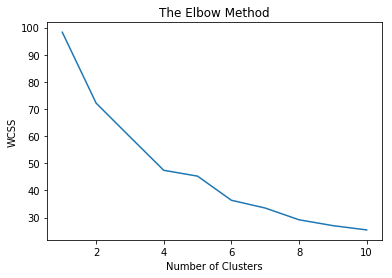

In [61]:
# finding the best value for K using the elbow method
import matplotlib.pyplot as plt
cluster_df = singapore_onehot.drop(['Neighborhood Group','Neighborhood', 'Venue'], axis=1)
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300,n_init= 10, random_state = 0)
    kmeans.fit(cluster_df)
    wcss.append(kmeans.inertia_)
# plotting a graph to find the best k value
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

running the algorithm again with the best value of K.

In [70]:

k_clusters = 6
cluster_df = singapore_onehot.drop(['Neighborhood Group','Neighborhood', 'Venue'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]


array([3, 0, 0, 3, 2, 2, 0, 1, 0, 3], dtype=int32)

Assigning the cluster labels to the dataframe

In [71]:
req_venues['cluster_group'] = kmeans.labels_

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Visualising the clusters in a map

In [72]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(req_venues['Venue Latitude'], req_venues['Venue Longitude'],req_venues['Neighborhood'], req_venues['cluster_group']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Examine Clusters

Cluster with good mix of venues belonging to different venue categories and with an average no of airbnb listings within two Km's from the venues.

In [73]:
req_venues.loc[req_venues['cluster_group']==0]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
1,Bukit Timah,Central Region,1.335491,103.818446,Adam Underpass,1.334230,103.818390,Tunnel,24.0,78.0,36.0,average,0
2,Southern Islands,Central Region,1.257288,103.823321,Adventure Cove Waterpark,1.258639,103.819451,Water Park,16.0,2.0,0.0,average,0
6,Bukit Panjang,West Region,1.390289,103.774450,Central Catchment Mountain Biking Trail,1.389332,103.772595,Trail,34.0,0.0,0.0,average,0
8,Bukit Timah,Central Region,1.335491,103.818446,Coast-to-Coast Trail,1.338751,103.819685,Trail,23.0,79.0,36.0,average,0
10,Southern Islands,Central Region,1.257288,103.823321,Dolphin Island,1.258611,103.819294,Aquarium,16.0,2.0,0.0,average,0
12,Bedok,East Region,1.314518,103.963586,East Coast Double Jetty,1.313993,103.963529,Pier,30.0,56.0,252.0,average,0
13,Marine Parade,Central Region,1.301993,103.919509,East Coast Park Area D,1.303297,103.921953,Beach,23.0,133.0,6.0,average,0
14,Bedok,East Region,1.314518,103.963586,East Coast Park Area G,1.314402,103.959101,Beach,45.0,67.0,226.0,average,0
15,Bedok,East Region,1.314518,103.963586,East Coast Park Area H,1.315794,103.964489,Beach,24.0,60.0,254.0,average,0
20,Bukit Batok,West Region,1.348935,103.770283,Former Ford Factory,1.352497,103.769071,Historic Site,38.0,19.0,0.0,average,0


Cluster that has venues that has high no of airbnb listings within 2 kms from the venues. 

In [74]:
req_venues.loc[req_venues['cluster_group']==1]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
7,Outram,Central Region,1.285435,103.847183,Chinatown Heritage Centre,1.283464,103.844223,History Museum,476.0,0.0,0.0,high,1
27,Toa Payoh,Central Region,1.343403,103.860437,Kallang Park Connector,1.342255,103.856293,Trail,95.0,14.0,0.0,high,1
46,Singapore River,Central Region,1.294130,103.842141,STPI - Creative Workshop & Gallery,1.290802,103.840211,Art Gallery,194.0,0.0,0.0,high,1
52,Outram,Central Region,1.285435,103.847183,Singapore River,1.288998,103.846958,River,476.0,0.0,0.0,high,1
54,Rochor,Central Region,1.299782,103.859423,Supermama Flagship Store,1.300435,103.860170,Art Gallery,966.0,5.0,0.0,high,1
56,Geylang,Central Region,1.313323,103.906706,That Aquarium (Eunos),1.317658,103.906431,Aquarium,174.0,817.0,0.0,high,1
57,Singapore River,Central Region,1.294130,103.842141,The Bicentennial Experience,1.295395,103.846080,History Museum,194.0,0.0,0.0,high,1
71,Woodlands,North Region,1.451500,103.776730,Woodlands Waterfront Jetty,1.453595,103.778045,Pier,51.0,27.0,0.0,high,1


Cluster that has Theme park Rides/Attractions and has average no of airbnb listsings within 2 kms.

In [75]:
req_venues.loc[req_venues['cluster_group']==2]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
4,Southern Islands,Central Region,1.257288,103.823321,Battlestar Galactica: Human vs. Cylon,1.253721,103.822259,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
5,Southern Islands,Central Region,1.257288,103.823321,Canopy Flyer,1.253768,103.824215,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
11,Southern Islands,Central Region,1.257288,103.823321,Donkey Live! (Far Far Away),1.254689,103.824193,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
17,Southern Islands,Central Region,1.257288,103.823321,Enchanted Airways,1.254907,103.823685,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
23,Southern Islands,Central Region,1.257288,103.823321,Hollywood Boulevard,1.255365,103.821929,Theme Park Ride / Attraction,17.0,1.0,0.0,average,2
24,Southern Islands,Central Region,1.257288,103.823321,Jurassic Park Rapids Adventure,1.253509,103.823769,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
28,Southern Islands,Central Region,1.257288,103.823321,King Julien's Beach Party-Go-Round,1.255334,103.823016,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
29,Southern Islands,Central Region,1.257288,103.823321,"Lights, Camera, Action!™ Hosted by Steven Spie...",1.254459,103.822214,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
31,Southern Islands,Central Region,1.257288,103.823321,Madagascar: A Crate Adventure,1.255617,103.822966,Theme Park Ride / Attraction,18.0,0.0,0.0,average,2
37,Southern Islands,Central Region,1.257288,103.823321,New York,1.254745,103.821488,Theme Park Ride / Attraction,17.0,1.0,0.0,average,2


Cluster that has Theme park  and has average no of airbnb listsings within 2 kms.

In [76]:
req_venues.loc[req_venues['cluster_group']==3]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
0,Southern Islands,Central Region,1.257288,103.823321,Accelerator,1.253760,103.821887,Theme Park,17.0,1.0,0.0,average,3
3,Southern Islands,Central Region,1.257288,103.823321,Ancient Egypt,1.253800,103.823107,Theme Park,18.0,0.0,0.0,average,3
9,Southern Islands,Central Region,1.257288,103.823321,Dino'soarin,1.253662,103.824297,Theme Park,18.0,0.0,0.0,average,3
18,Southern Islands,Central Region,1.257288,103.823321,Far Far Away,1.254894,103.823705,Theme Park,18.0,0.0,0.0,average,3
22,Southern Islands,Central Region,1.257288,103.823321,Hollywood Bay,1.255256,103.822128,Theme Park,17.0,1.0,0.0,average,3
48,Southern Islands,Central Region,1.257288,103.823321,Sci-Fi City,1.254081,103.821906,Theme Park,17.0,1.0,0.0,average,3
63,Southern Islands,Central Region,1.257288,103.823321,Universal Studios Singapore,1.254044,103.823810,Theme Park,18.0,0.0,0.0,average,3
64,Southern Islands,Central Region,1.257288,103.823321,Universal Studios Singapore - Guest Services L...,1.255570,103.822056,Theme Park,17.0,1.0,0.0,average,3
65,Southern Islands,Central Region,1.257288,103.823321,Universal Studios Singapore's Ticket Booth,1.256687,103.821351,Theme Park,16.0,2.0,0.0,average,3


Cluster that has venues which has only low no of airbnb listsings within 2 kms.

In [77]:
req_venues.loc[req_venues['cluster_group']==4]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
16,Punggol,North-East Region,1.400592,103.930179,East Promenade,1.403802,103.930727,Waterfront,7.0,34.0,1.0,low,4
25,Jurong East,West Region,1.298614,103.711867,Jurong Island Causeway @ OSR,1.297149,103.712415,Boat or Ferry,4.0,83.0,2.0,low,4
26,Jurong East,West Region,1.298614,103.711867,Jurong Port Berth @ Diamond Princess,1.299589,103.712475,Boat or Ferry,4.0,83.0,2.0,low,4
30,Punggol,North-East Region,1.400592,103.930179,Lorong Halus Jetty,1.398119,103.932487,Pier,2.0,35.0,5.0,low,4
32,Marina South,Central Region,1.281284,103.872517,Marina Barrage,1.281313,103.872460,Monument / Landmark,1.0,0.0,0.0,low,4
33,Marina South,Central Region,1.281284,103.872517,Marina Barrage Roof Top,1.280781,103.870935,Scenic Lookout,1.0,0.0,0.0,low,4
47,Marina South,Central Region,1.281284,103.872517,SailFun,1.280716,103.870713,Harbor / Marina,1.0,0.0,0.0,low,4
49,Mandai,North Region,1.435363,103.825884,Sembawang Hot Spring,1.433540,103.827685,Hot Spring,2.0,0.0,0.0,low,4
66,Marina South,Central Region,1.281284,103.872517,Water Playground,1.281290,103.870306,Water Park,1.0,0.0,0.0,low,4


Cluster that has Beach spots with high no of airbnb listings within 2 Kms.

In [78]:
req_venues.loc[req_venues['cluster_group']==5]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
19,Clementi,West Region,1.299295,103.758560,Fishing Jetty,1.296860,103.760660,Beach,116.0,0.0,0.0,high,5
39,Pasir Ris,East Region,1.382015,103.953216,Pasir Ris Park @ BBQ Pit 16,1.381025,103.956758,Beach,63.0,2.0,0.0,high,5
43,Marine Parade,Central Region,1.301993,103.919509,Relaxing@EastCoastPark,1.301762,103.916605,Beach,97.0,65.0,0.0,high,5
68,Clementi,West Region,1.299295,103.758560,West Coast Beach,1.297004,103.761358,Beach,116.0,0.0,0.0,high,5
69,Clementi,West Region,1.299295,103.758560,West Coast Breakwater,1.297004,103.760911,Beach,116.0,0.0,0.0,high,5


In [59]:
req_venues.loc[req_venues['cluster_group']==6]

,Neighborhood,Neighborhood Group,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,close stay,moderately close stay,far away stay,counts,cluster_group
